In [1]:
from pathlib import Path
import logging
import math

import pytorch_lightning as pl
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
import torch
import numpy as np
from torchvision import transforms
from pytorch_lightning import seed_everything
from tqdm import tqdm

from solarnet.utils.plots import plot_confusion_matrix, plot_image_grid
from solarnet.utils.target import flux_to_class_builder
from solarnet.utils.log import init_log, set_log_level
from solarnet.models import ImageClassification
from solarnet.data import SDOBenchmarkDataModule, SDODatasetDataModule, SDODataset
from solarnet.utils.yaml import load_yaml
from solarnet.data import datamodule_from_config
from solarnet.data.transforms import sdo_dataset_normalize, SDOSimCLRDataTransform
from solarnet.utils.plots import plot_confusion_matrix
from solarnet.utils.metrics import classification_metrics

init_log()
set_log_level(logging.INFO)

/home/jonathan.donzallaz/anaconda3/envs/solarnet-conda-env/lib/python3.8/site-packages/pytorch_lightning/core/decorators.py:64: LightningDeprecationWarning: The `@auto_move_data` decorator is deprecated in v1.3 and will be removed in v1.5. Please use `trainer.predict` instead for inference. The decorator was applied to `forward`
  rank_zero_deprecation(


In [5]:
# Parameters
parameters = {
    "data": {
        "validation_size": 0.1,
        "channel": "171",
        "size": 256,
        "time_steps": 3,#[0,1,2,3],
        "targets": {
            "classes": [{"Quiet": "< 1e-4"},{">=C": ">= 1e-4"}],
        },
    },
    "trainer": {
        "epochs": 5,
        "batch_size": 32,
    },
    "seed": 42,
    "system": {
        "workers": 20,
        "gpus": 0,
    }
}

In [6]:
# Load data
datamodule = SDOBenchmarkDataModule(
    Path("../") / "data" / "sdo-benchmark",
    batch_size=parameters["trainer"]["batch_size"],
    validation_size=parameters["data"]["validation_size"],
    channel=parameters["data"]["channel"],
    resize=parameters["data"]["size"],
    seed=parameters["seed"],
    num_workers=parameters["system"]["workers"],
    target_transform=flux_to_class_builder(parameters["data"]["targets"]["classes"]),
    time_steps=parameters["data"]["time_steps"],
)
datamodule.setup()

In [7]:
# TEMPORARY
sample = next(iter(datamodule.test_dataloader()))
samples = sample[0].squeeze()
samples[0].shape

torch.Size([256, 256])

In [8]:
sample[1]

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

TypeError: Invalid shape (256,) for image data

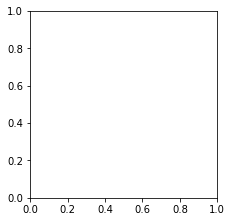

In [9]:
imgs = [i for i in samples[8]]
plot_image_grid(imgs, labels=["10 min", "1.5 hour", "5 hours", "12 hours"])

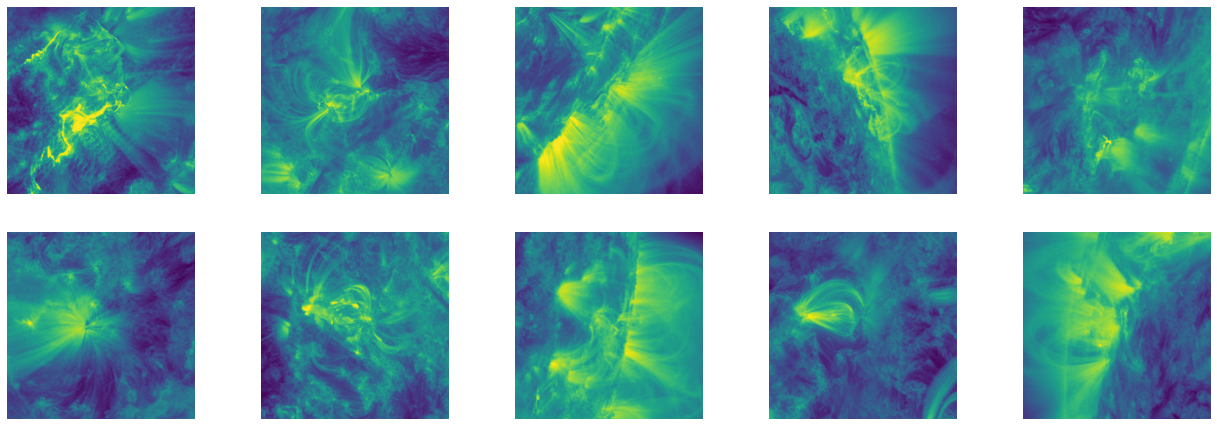

In [10]:
samples = next(iter(datamodule.train_dataloader()))[0].squeeze()
plot_image_grid(samples)

In [11]:
# Model
model = ImageClassification.from_pretrained(
    "solarnet-ssl-bz",
    print_incompatible_keys=True,
    
    n_class=2,
    n_hidden=512,
    dropout=0.5,
    learning_rate=2e-5,
)

INFO     | Model solarnet-ssl-bz found in cache
INFO     | Model solarnet-ssl-bz loaded with config:
INFO     | {'model': 'SimCLR', 'output_size': 2, 'backbone': 'resnet50', 'backbone_output_size': 2048, 'n_channel': 1, 'hparams': {'gpus': 1, 'num_samples': 2, 'batch_size': 3, 'dataset': None, 'num_nodes': 1, 'arch': 'resnet50', 'hidden_mlp': 2048, 'feat_dim': 64, 'warmup_epochs': 10, 'max_epochs': 100, 'temperature': 0.1, 'first_conv': True, 'maxpool1': True, 'optimizer': 'adam', 'exclude_bn_bias': False, 'start_lr': 0.0, 'learning_rate': 0.001, 'final_lr': 0.0, 'weight_decay': 1e-06, 'n_channel': 1, 'backbone': 'resnet50'}}
INFO     | Missing keys:
INFO     |     classifier.classifier: 8
INFO     | Unexpected keys:
INFO     |     projection.model: 8
INFO     |     non_linear_evaluator.block_forward: 8
INFO     |     backbone.fc: 2


In [12]:
# Train
trainer = pl.Trainer(
    gpus=parameters["system"]["gpus"],
    callbacks=[],
    max_epochs=parameters["trainer"]["epochs"],
    num_sanity_val_steps=0,
    sync_batchnorm=True,
    deterministic=True,
)

# trainer.fit(model, datamodule=datamodule)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/jonathan.donzallaz/anaconda3/envs/solarnet-conda-env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:596: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


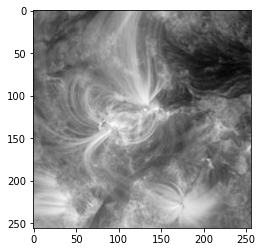

In [13]:
plt.imshow(samples[1], cmap="Greys_r");

In [14]:
samples[0]

tensor([[-0.0510, -0.0431,  0.0118,  ..., -0.0510, -0.0588, -0.0588],
        [-0.0824, -0.0745, -0.0196,  ..., -0.0667, -0.0667, -0.0667],
        [-0.0902, -0.0902, -0.0510,  ..., -0.0824, -0.0824, -0.0902],
        ...,
        [-0.2471, -0.2549, -0.2549,  ...,  0.3882,  0.3725,  0.3647],
        [-0.2471, -0.2549, -0.2549,  ...,  0.3961,  0.3882,  0.3882],
        [-0.2549, -0.2549, -0.2627,  ...,  0.4039,  0.4039,  0.4039]])

In [15]:
dm = SDOBenchmarkDataModule(Path("../data/sdo-benchmark"))
dm = SDODatasetDataModule(Path("../data/sdo-dataset-ssl-bz-1h-month"))
dm.setup()

In [16]:
dl = dm.train_dataloader()
batch = next(iter(dl))

In [17]:
# batch[0].shape
t = torch.tensor_split(batch[0], dm.batch_size)
t = [i[0,0] for i in t]
print(len(t), t[0].shape)

32 torch.Size([512, 512])


In [27]:
w = 22
m = 10
c = 3
h = w * (m // c) / c * 1.33 # 6
# print(h)
# height = 12
# height = max(height, int(len(images) / columns) * height)
# plot_image_grid(t, max_images=m, columns=c, width=w, height=h)
import math
math.ceil(8 / 5)

2

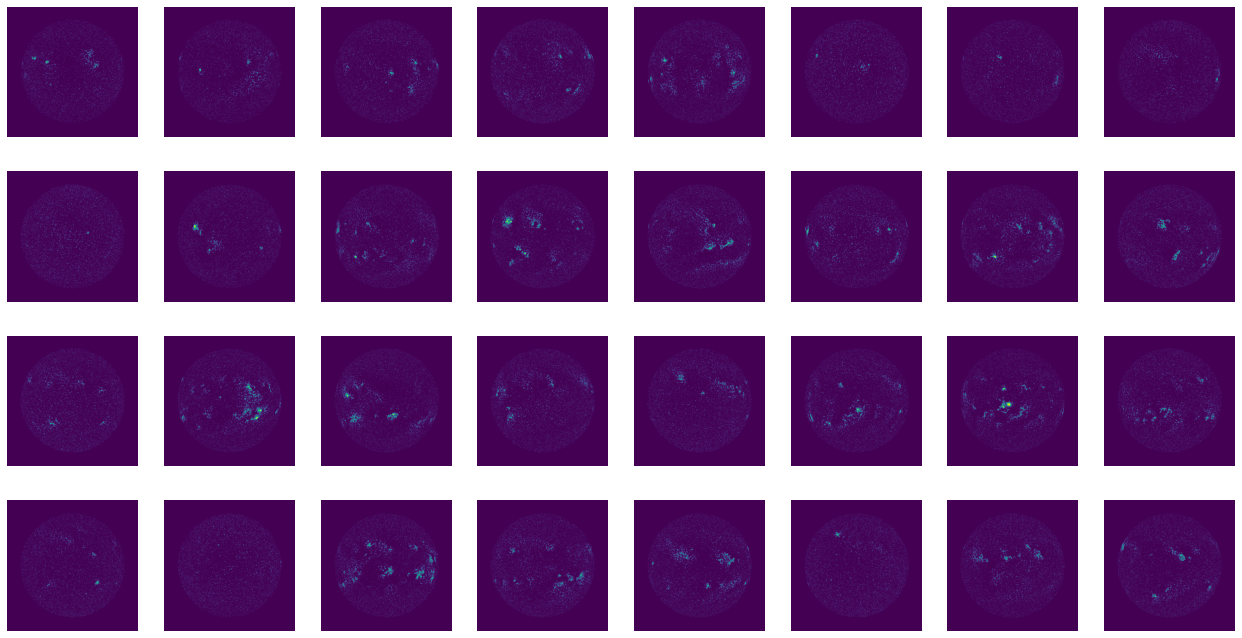

In [28]:
plot_image_grid(t, max_images=32, columns=8)

In [29]:
ds = dl.dataset
ds

In [30]:
[list(c.keys())[0] for c in [{"Quiet": "< 1e-6"},{">=C": ">= 1e-6"}]]

['Quiet', '>=C']

In [31]:
str(dm.size())

'(1, 512, 512)'

In [41]:
# path = Path("../models/baseline_binary_sdodataset")
path = Path("../models/ssl_bz_ft_sdodataset")
p = load_yaml(path / "config.yaml")
pl.seed_everything(p["seed"])
datamodule = datamodule_from_config(p)
model = ImageClassification.load_from_checkpoint(str(path / "model.ckpt"))
trainer = pl.Trainer(
    gpus=0,
    logger=None,
)
t = transforms.Compose(
    [
        transforms.CenterCrop((512 // 2, 512 - 512 // 8)),
        sdo_dataset_normalize(p["data"]["channel"], p["data"]["size"]),
    ]
)
datamodule = SDODatasetDataModule(
    # Path('../data/sdo-dataset-cls-211-24h-mix'),
    Path('../data/sdo-dataset-cls-bz-24h-2015-2017'),
    channel=p["data"]["channel"],
    target_transform=flux_to_class_builder(p["data"]["targets"]["classes"]),
    batch_size=p["trainer"]["batch_size"],
    resize=p["data"]["size"],
    num_workers=p["system"]["workers"],
    transform=t,
)
datamodule.setup("test")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/jonathan.donzallaz/anaconda3/envs/solarnet-conda-env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:596: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


In [42]:
p = trainer.predict(model, datamodule.test_dataloader())

Predicting: 0it [00:00, ?it/s]

In [43]:
p = torch.cat(p)
p = torch.argmax(p, dim=1).tolist()

In [44]:
len([i for i in p if i == 0])

681

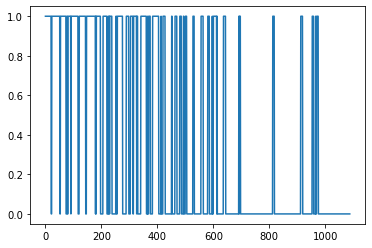

In [45]:
plt.plot(p);

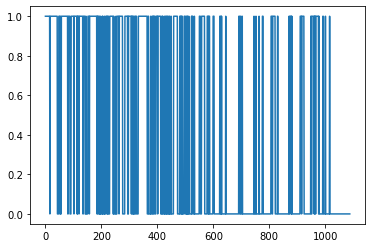

In [52]:
y_true = [y.item() for batch in datamodule.test_dataloader() for y in batch[1]]
plt.plot(y_true);

In [40]:
from solarnet.models import SimpleCNN
from torch import nn

backbone = SimpleCNN(1, pooling=0, stride=1, n_hidden=16)
output_size = backbone.output_size
backbone = nn.Sequential(
    backbone,
    # nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten(),
)
print(output_size)

TypeError: __init__() got an unexpected keyword argument 'n_hidden'

In [41]:
t = torch.rand((32,1,256,256))
print(t.shape)
backbone(t).shape

torch.Size([32, 1, 256, 256])


NameError: name 'backbone' is not defined

In [ ]:
backbone: 32, 64, 2, 2
pooling:  32, 64, 1, 1
flatten:  32, 256
both:     32, 64

In [42]:
seed_everything(42, workers=True)
base_resize = 512
transform = SDOSimCLRDataTransform(
    128,
    do_online_transform=True,
    transform_before=transforms.CenterCrop((base_resize // 2, base_resize - base_resize // 8)),
    transform_after=sdo_dataset_normalize(171),
)

dm = SDODatasetDataModule(Path("../data/sdo-dataset-ssl-171-1h-1"), channel=171, transform=transform)
dm.setup()
dl = dm.train_dataloader()
batch = next(iter(dl))

Global seed set to 42


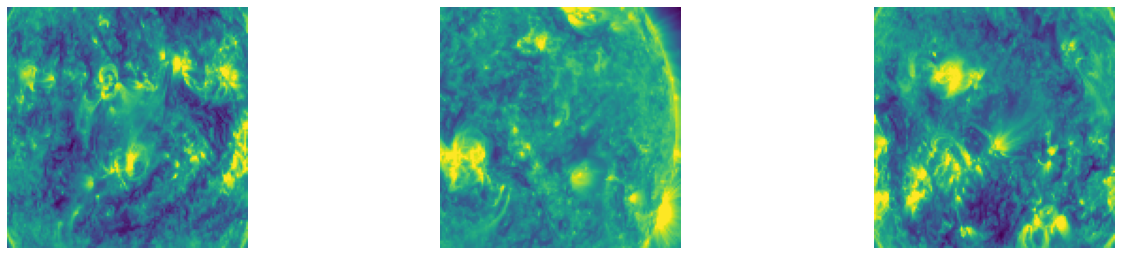

In [43]:
plot_image_grid([i[0] for i in batch[0][0]], max_images=3, columns=3)#, width=22, height=12)

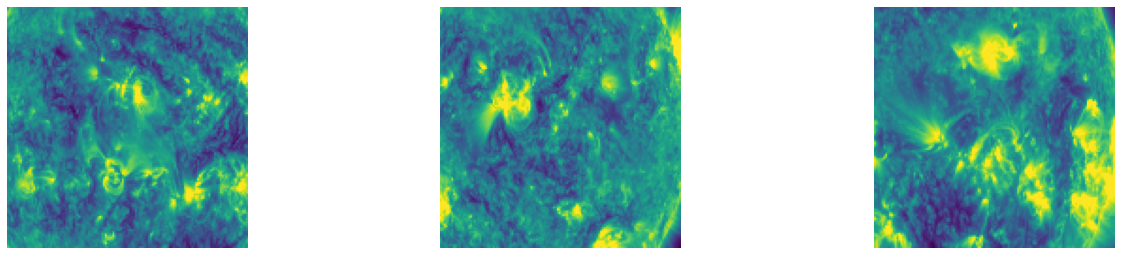

In [44]:
plot_image_grid([i[0] for i in batch[0][1]], max_images=3, columns=3)


In [45]:
plot_image_grid([i[0] for i in batch[0][3]], max_images=3, columns=3)

IndexError: list index out of range

Global seed set to 42


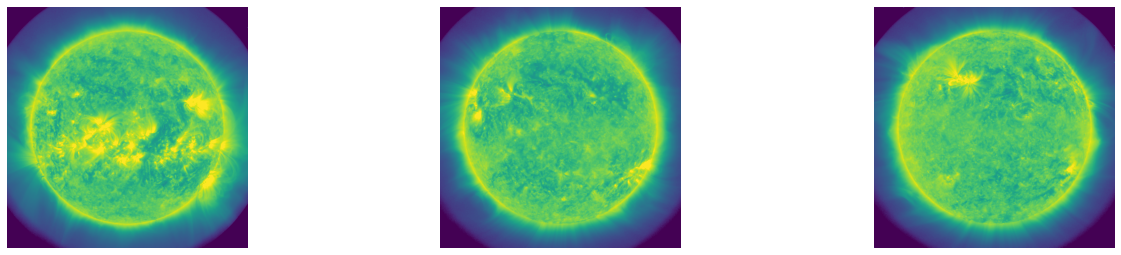

In [46]:
seed_everything(42, workers=True)
dm2 = SDODatasetDataModule(Path("../data/sdo-dataset-ssl-171-1h-1"), channel=171, transform=None)
dm2.setup()
dl2 = dm2.train_dataloader()
batch2 = next(iter(dl2))
plot_image_grid([i[0] for i in batch2[0]], max_images=3, columns=3)

In [33]:
import math
from typing import Callable, Optional, Union

import torch
from torchvision.transforms import transforms
import torchvision.transforms.functional as transforms_functional

# Same preprocess as github.com/i4Ds/SDOBenchmark
CHANNEL_PREPROCESS = {
    "171": {"min": 5, "max": 8500, "scaling": "log10"},
    # "171": {"min": 5, "max": 8500, "scaling": None},
    "193": {"min": 20, "max": 5500, "scaling": "log10"},
    "211": {"min": 7, "max": 3500, "scaling": "log10"},
    "magnetogram": {"min": -250, "max": 250, "scaling": None},
    "bx": {"min": -250, "max": 250, "scaling": None},
    "by": {"min": -250, "max": 250, "scaling": None},
    "bz": {"min": -250, "max": 250, "scaling": None},
}


def sdo_dataset_normalize(channel: Union[str, int], resize: Optional[int] = None):
    preprocess_config = CHANNEL_PREPROCESS[str(channel).lower()]

    lambda_transform = lambda x: torch.clamp(
        transforms_functional.vflip(x),
        min=preprocess_config["min"],
        max=preprocess_config["max"],
    )

    mean = preprocess_config["min"]
    std = preprocess_config["max"] - preprocess_config["min"]

    if preprocess_config["scaling"] == "log10":
        base_lambda = lambda_transform
        lambda_transform = lambda x: torch.log10(base_lambda(x))
        mean = math.log10(preprocess_config["min"])
        std = math.log10(preprocess_config["max"]) - math.log10(preprocess_config["min"])

    transform = [
        transforms.Lambda(lambda_transform),
        transforms.Normalize(mean=[mean], std=[std]),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]

    if resize is not None:
        transform.insert(0, transforms.Resize(resize))

    return transforms.Compose(transform)

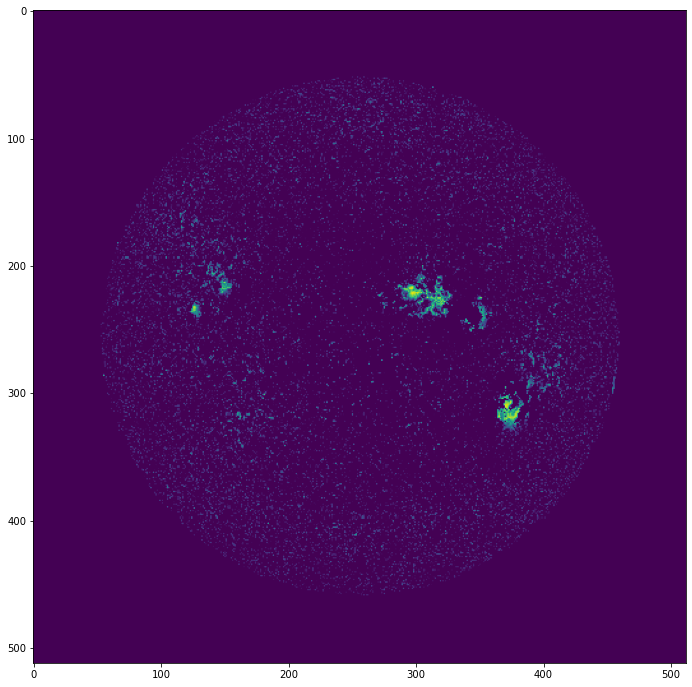

In [40]:

# img1 = "c:/code/master/AIA20110101_1200_0171.npz"
# img1 = "/data1/data/sdo-dataset/171/2017/09/06/AIA20170906_1200_0171.npz"
img1 = "/data1/data/sdo-dataset/Bz/2017/09/06/HMI20170906_1148_bz.npz"
# img2 = "c:/code/master/HMI20110101_1200_bz.npz"

img = np.load(img1)["x"].astype(np.float64)
img = torch.from_numpy(img).unsqueeze(0)
img = sdo_dataset_normalize(171)(img)
img = img[0].numpy()
plt.figure(figsize=(12, 12))
plt.imshow(img);
# plt.imshow(img, cmap="gray");
# plt.imshow(img, cmap="afmhot");
# plt.show();
# plt.imsave("c:/code/master/AIA20110101_1200_0171_clip.png",img, cmap="afmhot")
# plt.imsave("c:/code/master/AIA20110101_1200_bz_nopp.png",img, cmap="gray")
# images = crop_center(images, 430, 200)
# plt.imshow(images);




# All functions

In [2]:
def predict(tensor):
    while len(tensor.shape) < 4:
        tensor = tensor.unsqueeze(0)
    with torch.no_grad():
        y_pred = model(tensor)

    # Postprocess
    y_pred = torch.argmax(y_pred, dim=1)
    y_pred = y_pred.item()
    # y_pred = ["Quiet", ">=C"][y_pred]
    return y_pred

In [3]:
from datetime import datetime
from io import BytesIO
from pathlib import Path
import requests
from typing import Optional

from PIL import Image
import re

WAVELENGTH_TO_SOURCEID = {
    "94": 8,
    "131": 9,
    "171": 10,
    "193": 11,
    "211": 12,
    "304": 13,
    "335": 14,
    "1600": 15,
    "1700": 16,
    "4500": 17,
    "continuum": 18,
    "magnetogram": 19,
}
WAVELENGTH_TO_INSTRUMENT = {
    "94": "AIA",
    "131": "AIA",
    "171": "AIA",
    "193": "AIA",
    "211": "AIA",
    "304": "AIA",
    "335": "AIA",
    "1600": "AIA",
    "1700": "AIA",
    "4500": "AIA",
    "continuum": "HMI",
    "magnetogram": "HMI",
}

# API_URL = "https://helioviewer-api.ias.u-psud.fr//v2/getJP2Image/?date={}&sourceId={}"
# API_URL = "https://api.helioviewer.org/v2/getJP2Image/?date={}&sourceId={}"
# API_URL = "http://dmlab.cs.gsu.edu/dmlabapi/images/SDO/AIA/{}/?wave={}&starttime={}"
BASE_API_URL = "https://api.helioviewer.org/v2"
BACKUP_API_URL = "https://helioviewer-api.ias.u-psud.fr//v2"
GET_JP2_IMAGE_URL = "{}/getJP2Image/?date={}&sourceId={}"
GET_CLOSEST_IMAGE_DATA_URL = "{}/getClosestImage/?date={}&sourceId={}"


def get_image(date: datetime, wavelength: str = "magnetogram", save_path: Optional[Path] = None):
    url = GET_JP2_IMAGE_URL.format(BASE_API_URL, date.isoformat() + "Z", WAVELENGTH_TO_SOURCEID[wavelength])
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        img.save(save_path)
        save_path_1024 = save_path.parent / (save_path.stem + "_1024" + save_path.suffix)
        img.resize((1024, 1024), Image.LANCZOS).save(save_path_1024)

    return img

def get_closest_image_data(date: datetime, wavelength: str = "magnetogram"):
    url = GET_CLOSEST_IMAGE_DATA_URL.format(BASE_API_URL, date.isoformat() + "Z", WAVELENGTH_TO_SOURCEID[wavelength])
    response = requests.get(url)

    return response.json()

def get_save_image(date: datetime, wavelength: str = "magnetogram",):
    date_filtered = re.sub("[-:]", "", date.isoformat())
    instrument = WAVELENGTH_TO_INSTRUMENT[wavelength]
    path_str = f"static/images/{instrument}_{wavelength}_{date_filtered}.jpg"
    path = Path(path_str)

    if path.exists() and path.is_file():
        img = Image.open(path)
    else:
        img = get_image(date, save_path=path)
    
    return img

In [5]:
# current_size = 4096
# target_size = 512
# factor = current_size // target_size

# # divideFactor = int(4096 / 4)
# print(factor)
# Xr = skimage.transform.downscale_local_mean(Xr,(divideFactor,divideFactor))

In [6]:
# date = "2016-12-02T00:00:00"

# date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")
# img = get_save_image(date)
# t = preprocess_image(img)

In [7]:
# print(t.shape, type(t))
# t2 = skimage.transform.downscale_local_mean(t,(1, factor,factor))
# print(t2.shape, type(t2))
# t2t = torch.from_numpy(t2)
# t2t, t2t.shape
# t2t[0,256,256]

In [8]:
# t3t = torch.nn.functional.avg_pool2d(t, factor)
# t3t, t3t.shape
# t3t[0,256,256]

In [9]:
# t2t.equal(t3t)
# plt.figure(figsize=(15,15))
# plt.imshow(t2t.squeeze(), cmap="Greys_r");
# plt.show()
# plt.figure(figsize=(15,15))
# plt.imshow((t3t-t2t).squeeze(), cmap="Greys_r");

# 1. Predict correct class on a specific sample from the dataset

In [10]:
model_path = Path("../models/ssl_bz_ft_sdodataset_month")
data_path = Path("../data/sdo-dataset-cls-bz-24h-month/sdo-dataset-test.csv")
parameters = load_yaml(model_path / "config.yaml")
parameters

{'data': {'name': 'sdo-dataset',
  'channel': 'bz',
  'size': 128,
  'targets': {'classes': [{'Quiet': '< 1e-6'}, {'>=C': '>= 1e-6'}]},
  'path': 'data/sdo-dataset-cls-bz-24h-month'},
 'model': {'backbone': 'resnet50',
  'learning_rate': 2e-05,
  'n_hidden': 512,
  'dropout': 0.5,
  'lr_scheduler': False,
  'lr_scheduler_warmup_steps': 50},
 'trainer': {'epochs': 50, 'patience': 10, 'batch_size': 128},
 'name': 'Finetune SimCLR on SDO-Dataset, split by month',
 'training_type': 'finetune',
 'tune_lr': False,
 'path': 'models/ssl_bz_ft_sdodataset_month',
 'seed': 42,
 'tracking': True,
 'system': {'gpus': 1, 'workers': 20},
 'finetune': {'base': 'models/ssl_bz_month', 'backbone_unfreeze_epoch': 50},
 'tags': ['sdo-dataset']}

In [11]:
model = ImageClassification.load_from_checkpoint(model_path / "model.ckpt")
model.eval();

In [12]:
transform = transforms.Compose(
    [
        transforms.CenterCrop((512 // 2, 512 - 512 // 8)),
        sdo_dataset_normalize(parameters["data"]["channel"], parameters["data"]["size"]),
    ]
)
target_transform = flux_to_class_builder(parameters["data"]["targets"]["classes"])

#### From dataset

In [13]:
ds = SDODataset(data_path, transform=transform, target_transform=target_transform)

path_0_before    Bz/2016/12/02/HMI20161202_0000_bz.npz
peak_flux                                          0.0
datetime                           2016-12-02 00:00:00
all_found                                         True
split                                             test
Name: 176, dtype: object
label: 0


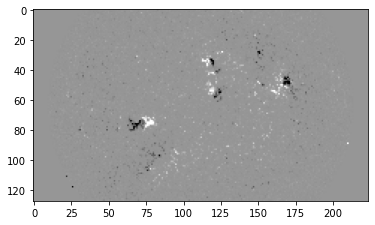

In [14]:
# index = 170
index = 176
print(ds.dataset.iloc[index])
print("label:", ds[index][1])
plt.imshow(ds[index][0].squeeze(), cmap="Greys_r");

In [15]:
predict(ds[index][0])

0

#### From path

In [16]:
tensors = [torch.from_numpy(np.load(data_path.parent / path)["x"]) for path in ["Bz/2015/12/24/HMI20151224_0000_bz.npz"]]
tensor = torch.stack(tensors)
tensor = transform(tensor)

In [17]:
predict(tensor)

1

In [18]:
print(tensor.shape)
print(tensor[0][0][0])
print(tensor[0][64][112])
print(tensor.min())
print(tensor.max())
print(tensor.mean())
print(tensor.std())

torch.Size([1, 128, 224])
tensor(0.)
tensor(0.0004)
tensor(-1.)
tensor(1.)
tensor(0.0008)
tensor(0.0881)


# 2. Predict something from a downloaded sample

# 3. Reproduce preprocessing on a downloaded sample

# 4. Predict correct class on a downloaded sample

# 5. Add caching

# 6. Clean code

2022-03-06T09:00:00:


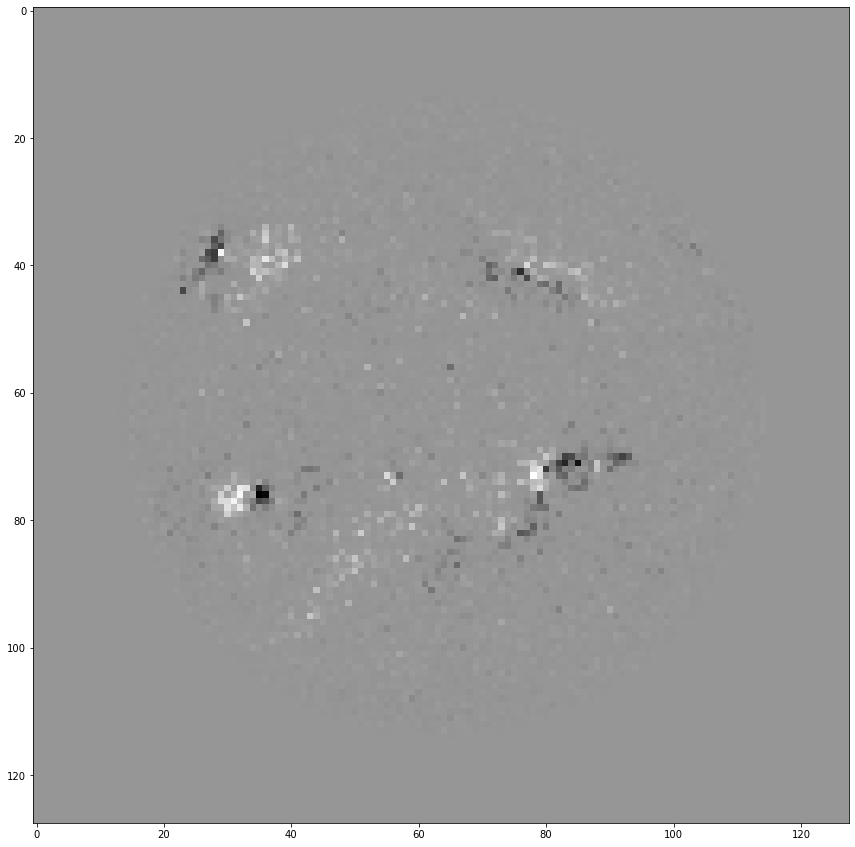

In [77]:
import skimage.transform

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def preprocess_image(img: Image.Image, resize: int = 128, scale: float = 0.6):
    size = img.size[0]

    # Remove black background around the sun in jpg images

    # hd.RSUN_OBS/hd.CDELT1 = 1625 -> 1625*2=3250 -> 3250 / 4096 = 0.79... --> RSUN_OBS/CDELT1 / 4096 =~ 0.3970
    # mask = create_circular_mask(size, size, center=(size//2, size//2), radius=size * 0.4)
    R_SUN = 976
    radius_pixels = R_SUN / scale  # ~= 1626px (for a 4096x4096 image)
    radius_factor = radius_pixels / 4096
    radius_factor *= 0.983  # to remove black margin around the sun

    mask = create_circular_mask(size, size, center=(size//2+1, size//2-1), radius=size * radius_factor)
    def remove_background(x):
        x_copy = x.clone()
        if len(x.shape) == 3:
            x_copy[0][~mask] = 0.5
        else:
            x_copy[~mask] = 0.5
        return x_copy
    
    # Downsizing by averaging in local blocks
    target_mean_size = max(512, resize)
    # target_mean_size = resize
    factor = size // target_mean_size
    mean_downsize = lambda x: torch.nn.functional.avg_pool2d(x, factor)

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Lambda(remove_background),
            transforms.Lambda(mean_downsize),
            # transforms.CenterCrop((target_mean_size // 2, target_mean_size - target_mean_size // 8)),
            transforms.Resize(resize),
            # transforms.Resize(resize, interpolation=transforms.InterpolationMode.BICUBIC),
            # transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
    )
    return transform(img)

def get_img_and_show(date: str):
    date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")
    img = get_save_image(date)
    img_data = get_closest_image_data(date)
    scale = img_data["scale"]

    tensor = preprocess_image(img, scale=scale)
    plt.figure(figsize=(15,15))
    plt.imshow(tensor.squeeze(), cmap="Greys_r");
    plt.show();

dates = [
    # "2015-12-24T00:00:00",
    # "2016-11-02T00:00:00",
    # "2016-09-02T00:00:00",
    # "2016-07-02T00:00:00",
    # "2016-06-02T00:00:00",
    # "2010-06-02T00:00:00",
    # "2010-12-02T00:00:00",
    # "2021-06-02T00:00:00",
    # "2021-12-02T00:00:00",
    "2022-03-06T09:00:00",
]
for date in dates:
    print(f"{date}:")
    get_img_and_show(date)

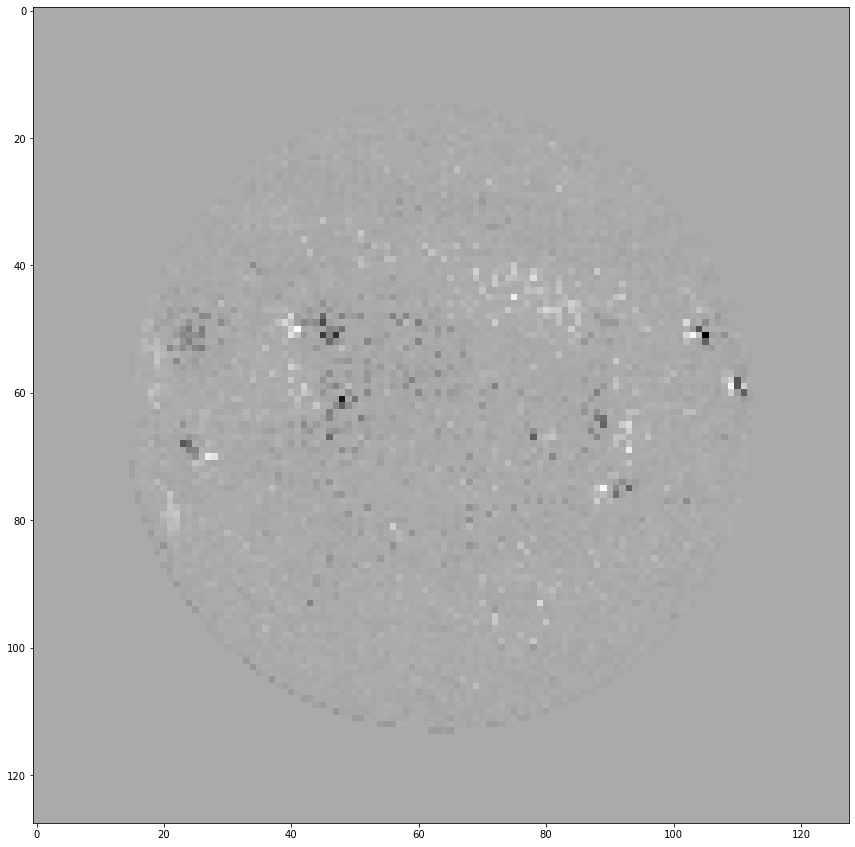

0

In [35]:
# date = "2015-12-24T00:00:00"
# date = "2016-12-02T00:00:00"  # 0.5915222892920654  -  973.39862   - 60000002      - 0.4028 - 0.396
date = "2016-06-02T00:00:00"  # 0.6085137616494966  -  946.21832   - 60000002    - 0.3915 - 0.385

date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")
img = get_save_image(date)

# tensor = preprocess_image(img.resize((1024, 1024), Image.LANCZOS))
# plt.figure(figsize=(15,15))
# plt.imshow(tensor.squeeze(), cmap="Greys_r");
# plt.show();
# predict(tensor)

tensor = preprocess_image(img)
plt.figure(figsize=(15,15))
plt.imshow(tensor.squeeze(), cmap="Greys_r");
plt.show();
predict(tensor)

In [162]:
print(tensor.shape)
print(tensor[0][0][0])
print(tensor[0][64][112])
print(tensor.min())
print(tensor.max())
print(tensor.mean())
print(tensor.std())

torch.Size([1, 128, 224])
tensor(0.)
tensor(-0.0118)
tensor(-1.)
tensor(1.)
tensor(-0.0002)
tensor(0.0754)


# 7. Test complete batch of downloaded samples

In [13]:
samples = []

l = len(ds)
for i, s in enumerate(ds):
    # print(i)
    sample = ds.dataset.iloc[i]
    # print(sample.datetime.to_pydatetime(), type(sample.datetime.to_pydatetime()))
    # print("label:", ds[i][1])
    # break
    samples.append((sample.datetime.to_pydatetime(),ds[i][1]))

In [14]:
samples[:3]

[(datetime.datetime(2010, 12, 2, 0, 0), 0),
 (datetime.datetime(2010, 12, 3, 0, 0), 0),
 (datetime.datetime(2010, 12, 4, 0, 0), 0)]

In [15]:
y_preds = []
for date, label in tqdm(samples):
    img = get_save_image(date)
    # tensor = preprocess_image(img.resize((1024, 1024), Image.LANCZOS))
    tensor = preprocess_image(img)
    y_pred = predict(tensor)
    y_preds.append(y_pred)

100%|██████████| 265/265 [11:00<00:00,  2.49s/it]


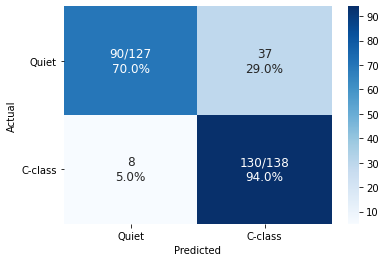

In [16]:
y = [i[1] for i in samples]
plot_confusion_matrix(y, y_preds, labels=["Quiet", "C-class"])

In [17]:
classification_metrics(torch.tensor(y), torch.tensor(y_preds))

{'accuracy': 0.8301886916160583,
 'balanced_accuracy': 0.8253452181816101,
 'f1': 0.826229453086853,
 'far': 0.2215568862275449,
 'hss': 0.6566665706964558,
 'pod': 0.9420289855072463,
 'csi': 0.7428571428571429,
 'tss': 0.6506904028300808}

# 8. From FITS files

In [129]:
import drms
import urllib

def _nearest(pivot, items):
    """Returns nearest point"""
    return min(items, key=lambda x: abs(x - pivot))


def _get_urls_hmi_b720(client, mag_time):
    """Returns for #download_magnetogram_hmi needed urls for hmi.B_720s

    Args:
        client (drms.Client): To query and return urls.
        mag_time (datetime.datetime): To find nearest magnetogram.

    Returns:
        generator that yields (datetime.datetime, str): Time of magnetogram,
            suffix url of magnetogram
    """
    import drms
    query_string = 'hmi.B_720s'
    query_string += f'[{mag_time.year}.'
    query_string += f'{str(mag_time.month).zfill(2)}.'
    query_string += f'{str(mag_time.day).zfill(2)}_'
    query_string += f'{str(mag_time.hour).zfill(2)}'
    query_string += '/1h]'
    data = client.query(query_string, key='T_REC', seg='field')
    times = drms.to_datetime(data[0].T_REC)
    nearest_time = _nearest(mag_time, times)
    # Generator to find the nearest time
    urls = ((data_time, mag_url) for (data_time, mag_url)
            in zip(times, data[1].field) if data_time == nearest_time)
    return urls



hmi_map='hmi.B_720s'
date = "2015-12-24T00:00:00"
mag_time = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")

get_urls = {
    'hmi.B_720s': _get_urls_hmi_b720,
    # 'hmi.b_synoptic_small': _get_urls_hmi_b_synoptic_small,
}
client = drms.Client()

urls = get_urls[hmi_map](client, mag_time)
print(urls)

# Download data
print('Starting download of magnetograms:\n')
return_name = ''
download_dir = ""
if not download_dir.endswith('/') and download_dir != '':
    download_dir += '/'
for data_time, mag_url in urls:
    if mag_url == 'BadSegLink':  # JSOC will return this if not found
        raise FileNotFoundError('Could not find those HMI magnetograms.')
    filename = 'hmi_' + str(data_time).replace(' ', '_')  # Add timestamp
    filename += '_' + mag_url.split('/')[-1]  # Last is filename
    url = 'http://jsoc.stanford.edu' + mag_url
    print(f'Downloading from {url} to {download_dir+filename}.')
    with urllib.request.urlopen(url) as fits_file:
        with open(download_dir+filename, 'wb') as local_file:
            local_file.write(fits_file.read())
    print(f'Done writing {download_dir+filename}.\n')
    return_name = download_dir+filename

print('Completed downloads.\n')

print( return_name)


<generator object _get_urls_hmi_b720.<locals>.<genexpr> at 0x7f5797f73dd0>
Starting download of magnetograms:

Done writing hmi_2017-12-24_00:00:00_field.fits.

Completed downloads.

hmi_2017-12-24_00:00:00_field.fits


# Download

In [57]:
import pandas as pd
df = pd.read_csv("../downloaded_data.csv",names=["id", "date", "name", "scale", "width", "height", "refPixelX", "refPixelY", "requested_date", "path", "observatory", "instrument", "wavelength"])

In [ ]:
R_SUN = 976
radius_pixels = R_SUN / scale  # ~= 1626px (for a 4096x4096 image)
radius_factor = radius_pixels / 4096
radius_factor *= 0.983  # to remove black margin around the sun

mask = create_circular_mask(size, size, center=(size//2+1, size//2-1), radius=size * radius_factor)
def remove_background(x):
    x_copy = x.clone()
    if len(x.shape) == 3:
        x_copy[0][~mask] = 0.5
    else:
        x_copy[~mask] = 0.5
    return x_copy

# Downsizing by averaging in local blocks
target_mean_size = max(512, resize)
# target_mean_size = resize
factor = size // target_mean_size
mean_downsize = lambda x: torch.nn.functional.avg_pool2d(x, factor)

In [81]:
paths = df["path"].tolist()
scales = df["scale"].tolist()
paths = paths[0::200]
scales = scales[0::200]
# type(ls), len(ls), ls[:3]
# to_tensor = transforms.ToTensor()
# factor = 4096 // 512
# mean_downsize = lambda x: torch.nn.functional.avg_pool2d(x, factor)
# transform = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         # transforms.Lambda(remove_background),
#         transforms.Lambda(mean_downsize),
#         # transforms.CenterCrop((target_mean_size // 2, target_mean_size - target_mean_size // 8)),
#         # transforms.Resize(resize),
#         # transforms.Resize(resize, interpolation=transforms.InterpolationMode.BICUBIC),
#         # transforms.Normalize(mean=[0.5], std=[0.5]),
#     ]
# )

mean_intensities = []
for path, scale in tqdm(zip(paths, scales)):
    img = Image.open(path, formats=["JPEG2000"])
    # img.thumbnail((1, 1))
    # avg_color = img.getpixel((0,0))
    # t = transform(img)
    t = preprocess_image(img, resize=512, scale=scale)
    mean_intensities.append(t.mean().item())

493it [16:18,  1.98s/it]


In [83]:
sum(mean_intensities)/len(mean_intensities)

0.5003710957980785

In [85]:
mi = 0
for i, m in enumerate(mean_intensities):
    if m > 0.6638:
        mi = i
mi

84

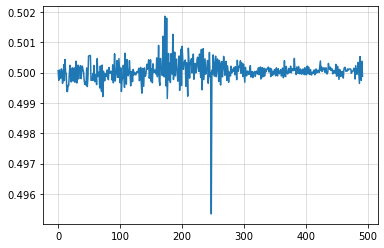

In [94]:
ys = mean_intensities[:84] + mean_intensities[85:]
xs = [x for x in range(len(ys))]
plt.grid(alpha=0.5)
plt.plot(xs, ys)

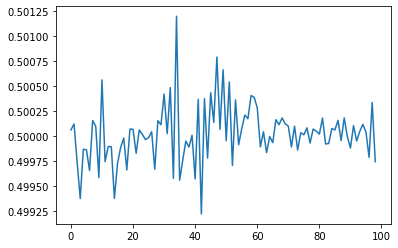

In [80]:
ys = mean_intensities
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)

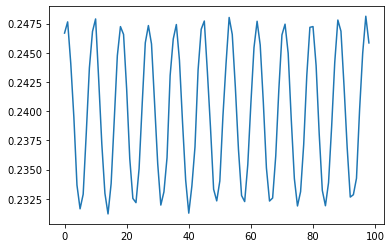

In [75]:
ys = mean_intensities
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)

In [78]:
# paths = df[["path", "scale"]].tolist()

AttributeError: 'DataFrame' object has no attribute 'tolist'

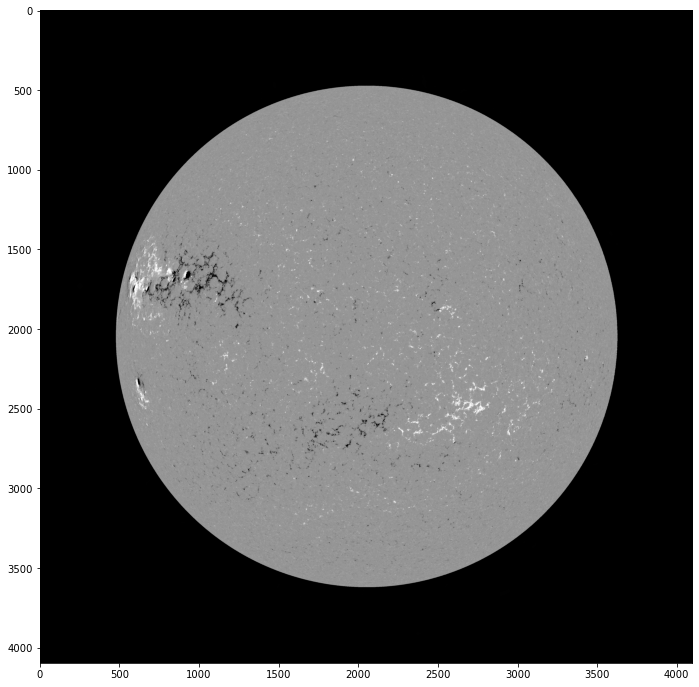

In [96]:
path = paths[200]
img = Image.open(path)
plt.figure(figsize=(12, 12))
plt.imshow(img, cmap="Greys_r");

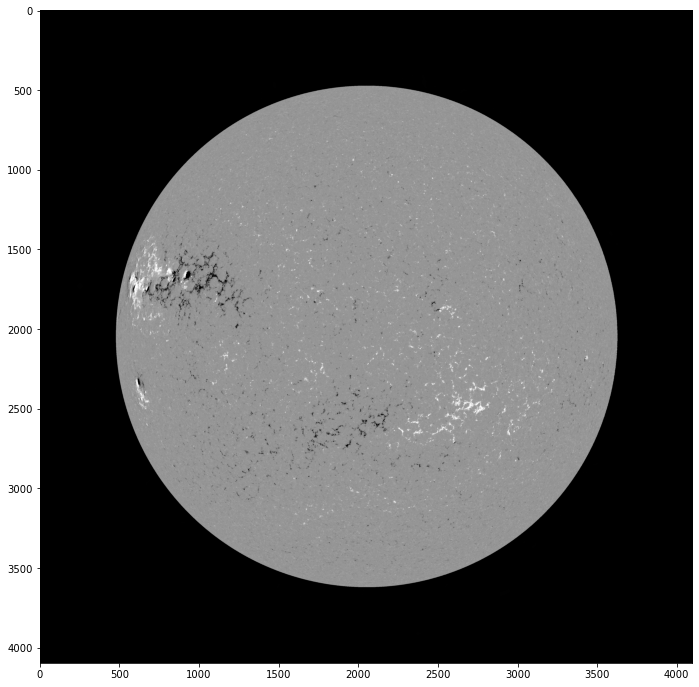

In [112]:
img2 = transforms.functional.affine(img, angle=0, translate=[0,0], scale=1, shear=0)
plt.figure(figsize=(12, 12))
plt.imshow(img2, cmap="Greys_r");

In [116]:
t = preprocess_image(img)
t.shape

torch.Size([1, 128, 128])

In [117]:
torch.save(t, "./tensor.pt")

In [115]:
path

'/data1/data/sdo-dataset-jp2/HMI_magnetogram_20150630T070000.jp2'